## Optimization Example Notebook
Here is an example of how to setup a simple optimization test using the gradients calculated using 
JAX's automatic differentiation capabilities. 

In this notebook we setup a forward function wrapper, loss function to optimize over, and a basic gradient desent optimization loop as a basic optimization example

In [1]:
from jcm.model import Model
import jax
import jax.numpy as jnp
from jcm.physics.speedy.speedy_physics import SpeedyPhysics
from jcm.physics.speedy.params import Parameters

In [ ]:
# Setup function requirements
def create_model(parameters, time_step = 30, layers = 8): 
    """Return speedy model with given parameters and specifications

    Args:
        parameters: parameters object type (jcm.paramters)
        time_step: Model time step in minutes
        layers: Number of vertical layers

    """
    return Model(time_step = time_step, 
                 layers = layers,
                 physics = SpeedyPhysics(parameters = parameters))

def average_pred(predictions):
    """Average over predictions"""
    leaves_d = jax.tree_util.tree_leaves(predictions.dynamics)
    avgs_d = jnp.array([jnp.mean(leaf) for leaf in leaves_d])
    leaves_p = jax.tree_util.tree_leaves(predictions.physics)
    avgs_p = jnp.array([jnp.mean(leaf) for leaf in leaves_p])
    return jnp.concatenate((avgs_d, avgs_p))


def forward_model_wrapper(theta, theta_keys, parameters = None, state = None, args = (),  save_interval = 1.0, total_time = 5.0):
    """Return forward model run collapsed into a single vector

    Args:
        theta: parameters of interest (find the parameters that minimize the loss function)
        theta_keys: dictionary with parameter names 
        parameters: parameters object type (jcm.parameters)
        state: state object type (jcm.State)
        args: additional arguments for creating the model
        save_interval: Save interval in days
        total_time: Total integration time in days

    """
    parameters = parameters or Parameters.default()

    ii = 0
    for attr, params in theta_keys.items():
        for param in params:
            setattr(getattr(parameters, attr), param, theta[ii])
            ii += 1
        
    model = create_model(parameters, *args)
    model_predictions = model.run(state, save_interval = save_interval, total_time = total_time)
    return average_pred(model_predictions)
   

def loss_function(theta, forward_model, y, R_inv_sqrt, args = ()): 
    """Return data-model misfit (i.e. loss function to optimize over)

    Args:
        theta: parameters of interest (find the parameters that minimize the loss function)
        forward_model: forward run through model with output the same shape as y
        y: data to compare model to (must be 1D vector)
        R_inv_sqrt: inverse square root of R (the assumed data errors associated to data)
        args: additional forward model function inputs

    """
    return 0.5*jnp.linalg.norm(R_inv_sqrt*(y - forward_model(theta, *args)))**2

In [ ]:
# Run forward function for true parameters
true_params = Parameters.default()  # True parameters are default parameters
model = create_model(true_params) # Create model
predictions = model.run(save_interval=1.0, total_time=5.0)  # run model forward for a total of 5 days

In [4]:
# Create synthetic data
y = average_pred(predictions)
# Assumed errors
R_inv_sqrt = jnp.ones_like(y)

In [5]:
# Set paramters to estimate
params = Parameters.default()  # Set all other parameters
theta = jnp.array([jnp.array(0.10)])  # Choose initial guess for estimating parameter/s
theta_keys = {"shortwave_radiation": ["albcls"]} # Define parameter/s to be estimated

# Define hyperparameters
step_size = 5e-6
num_iters = 7

In [ ]:
# Loss function gradient function
grad_loss_fn = jax.grad(loss_function, argnums = 0) # Uses jax.grad to calculate gradient

# Optimization loop
thetas_GD = []
thetas_GD.append(theta)
for i in range(num_iters): # Loop run time will take a while on laptop (about 5 minutes per iteration)
    grad = grad_loss_fn(theta, forward_model_wrapper, y, R_inv_sqrt,
                         args = (theta_keys, params)) # Compute gradient
    print("The gradient is: ", grad[0])
    theta -= step_size * grad[0]  # Gradient descent update
    print(f"Iteration {i+1}: theta = {theta}")
    thetas_GD.append(theta)

The gradient is:  -35791.11
Iteration 1: theta = [0.27895555]
The gradient is:  -19858.006
Iteration 2: theta = [0.3782456]
The gradient is:  -10963.168
Iteration 3: theta = [0.43306142]
The gradient is:  -6037.1597
Iteration 4: theta = [0.4632472]
The gradient is:  -3315.659
Iteration 5: theta = [0.4798255]
The gradient is:  -1821.228
Iteration 6: theta = [0.48893163]
The gradient is:  -1000.08496
Iteration 7: theta = [0.49393204]


In [ ]:
# Calculating loss function over [0,1] range
params = Parameters.default()  # Set default paramters
# Loss function loop for albcls
thetas = jnp.arange(0.0, 1.0, 0.025)
losses = []
for ii in range(len(thetas)):
    theta = jnp.array([jnp.array(thetas[ii])])
    losses.append(loss_function(theta, forward_model_wrapper, y, R_inv_sqrt,
                         args = (theta_keys, params)))

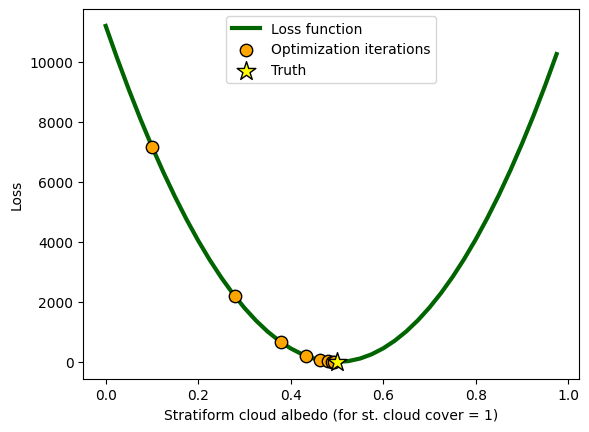

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.plot(thetas, losses, linewidth = 3, color = "darkgreen",  # plot loss function
         zorder = 0, label = "Loss function")
coeffs = jnp.polyfit(np.array(thetas), np.array(losses), deg=2) # plot gradient descent steps
gd_thetas = jnp.array(thetas_GD) 
gd_losses = jnp.polyval(coeffs, gd_thetas)
plt.scatter(gd_thetas, gd_losses, label = "Optimization iterations",
            s = 80, marker = 'o', color = "orange", zorder = 1, edgecolors = "black")
plt.scatter(0.50, 0, label = "Truth", # plot truth
            marker = "*", color = "yellow", zorder = 2, s = 200, edgecolors = "black")
plt.xlabel("Stratiform cloud albedo (for st. cloud cover = 1)")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.show()